In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# 1. Data loading and preparation

In [3]:
# data source: https://snap.stanford.edu/data/facebook-large-page-page-network.html

nodes = pd.read_csv("musae_facebook_target.csv")
edges = pd.read_csv("musae_facebook_edges.csv")
edges = edges.astype("int")

In [4]:
nodes.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [5]:
with open("musae_facebook_features.json") as json_data:
    data = json.load(json_data)

col_names = []
for i in range(31):
    a = '{}{}'.format('f', i)
    col_names.append(a)

features = pd.DataFrame.from_dict(data=data, orient='index', columns=col_names)
features = features.iloc[:, :10]
features['id'] = features.index
features.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,id
554,2835,4518,2198,2014.0,3818.0,3045.0,4570.0,4585.0,4596.0,4599.0,554
10772,3293,2534,979,2014.0,2317.0,NaN,NaN,NaN,NaN,NaN,10772
6350,4477,2895,4039,3282.0,765.0,2669.0,NaN,NaN,NaN,NaN,6350
9218,3133,2052,979,3355.0,107.0,1878.0,1105.0,4571.0,4582.0,4593.0,9218
7787,1151,631,2613,2791.0,648.0,1684.0,3818.0,107.0,1878.0,1105.0,7787


In [6]:
# impute null values with mean values

features_name = []
for i in range(10):
    a = '{}{}'.format('f',i)
    features_name.append(a)

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
features_tf = imputer.fit_transform(features.iloc[:, :-1])
features_tf = pd.DataFrame(features_tf, columns=features_name, index = features.index)
features_tf = features_tf.astype('int')
features_tf.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
554,2835,4518,2198,2014,3818,3045,4570,4585,4596,4599
10772,3293,2534,979,2014,2317,2397,2530,2890,3440,4055
6350,4477,2895,4039,3282,765,2669,2530,2890,3440,4055
9218,3133,2052,979,3355,107,1878,1105,4571,4582,4593
7787,1151,631,2613,2791,648,1684,3818,107,1878,1105


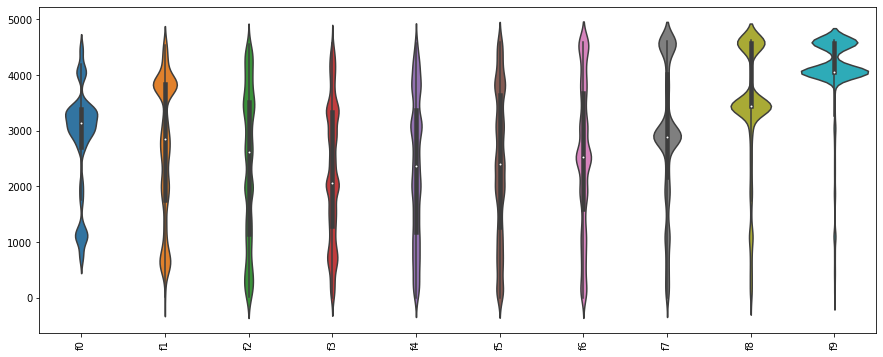

In [7]:
# check data distribution of feature_tf df

plt.figure(figsize=(15,6))
ax = sns.violinplot(data=features_tf)
_ = ax.set_xticklabels(features_name, rotation=90)

In [8]:
# detect outliers

q25 = features_tf.quantile(0.25)
q75 = features_tf.quantile(0.75)
iqr = q75-q25

mask = (features_tf < (q25 - 1.5*iqr)) | (features_tf > (q75 + 1.5*iqr)) # set the cap
features_tf[mask] = np.nan # set the cap from the dataframe

In [9]:
# concatenate with id var

features_tf = pd.concat([features_tf, features.id], axis=1)
features_tf.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,id
554,2835.0,4518,2198,2014,3818,3045,4570,4585,4596.0,4599.0,554
10772,3293.0,2534,979,2014,2317,2397,2530,2890,3440.0,4055.0,10772
6350,NaN,2895,4039,3282,765,2669,2530,2890,3440.0,4055.0,6350
9218,3133.0,2052,979,3355,107,1878,1105,4571,4582.0,4593.0,9218
7787,NaN,631,2613,2791,648,1684,3818,107,1878.0,NaN,7787


In [10]:
# drop nan values from outlier detection

features_tf.dropna(inplace=True) 
features_tf.shape

(15097, 11)

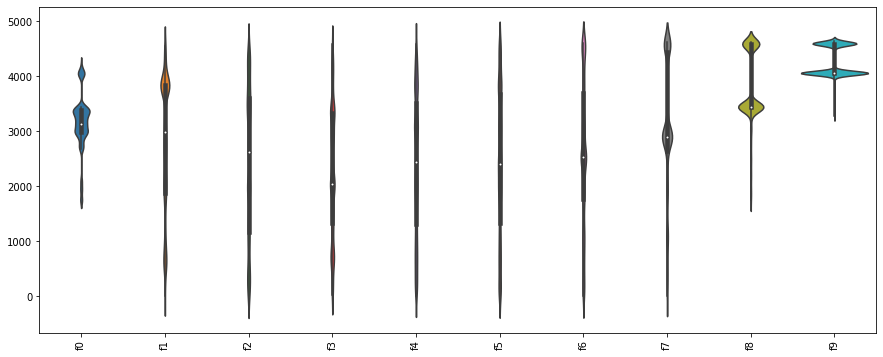

In [11]:
plt.figure(figsize=(15,6))
ax2 = sns.violinplot(data=features_tf.iloc[:, :-1])
_ = ax2.set_xticklabels(features_name, rotation=90)

In [12]:
# normalize the data

from sklearn.preprocessing import PowerTransformer

mm = PowerTransformer(method='yeo-johnson', standardize=True)
features_scaled = mm.fit_transform(features_tf.iloc[:, :-1])
features_scaled = pd.DataFrame(features_scaled, columns=features_name, index = features_tf.index)
features_scaled = pd.concat([features_scaled, features_tf.id], axis=1)
features_scaled.id = features_scaled.id.astype('int')

In [13]:
features_scaled.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,id
554,-0.721014,1.501743,-0.054615,-0.108873,1.084981,0.501949,1.431684,1.310720,1.237244,0.0,554
10772,0.206186,-0.246813,-0.972864,-0.108873,0.018209,0.055201,0.018834,-0.126381,-0.578491,0.0,10772
9218,-0.131254,-0.637691,-0.972864,0.949493,-1.919854,-0.320212,-1.074807,1.298525,1.214187,0.0,9218
756,0.075834,1.202465,-1.614908,-0.700027,0.395268,-0.655792,1.433014,1.312462,1.227359,0.0,756
21527,0.402328,0.875389,1.298154,1.379728,0.029391,0.173807,0.527895,-2.200415,-0.578491,0.0,21527


In [14]:
# merge features into nodes dataframe

nodes = nodes.merge(features_scaled, how ='inner', on='id')
nodes.head()

,id,facebook_id,page_name,page_type,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0,145647315578475,The Voice of China 中国好声音,tvshow,-0.131254,0.869105,-1.683075,-1.142460,-0.969167,-1.837855,-1.097072,-1.665095,-0.578491,0.0
1,1,191483281412,U.S. Consulate General Mumbai,government,0.437673,-1.687458,-0.972864,-0.108873,0.025665,0.055201,0.018834,-0.126381,-0.578491,0.0
2,2,144761358898518,ESET,company,0.402328,0.875389,-0.168578,-1.253395,1.189599,0.714737,-1.451693,-0.712931,1.196089,0.0
3,3,568700043198473,Consulate General of Switzerland in Montreal,government,-0.953259,-0.710372,-0.235980,1.789984,1.436042,-1.215752,-0.176855,-1.346061,-0.578491,0.0
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician,-0.648631,1.501743,1.419882,-0.462310,0.866494,1.415991,-0.441040,-0.126381,-0.578491,0.0


In [15]:
# 3. Graph Creation

In [16]:
# remove id from edges which are not in nodes

node_id_unique = list(nodes.id.unique())
edges = edges[edges['id_1'].isin(node_id_unique)]
edges = edges[edges['id_2'].isin(node_id_unique)]

In [17]:
import networkx as nx 

G = nx.Graph()

# add nodes
for node in nodes.iloc[:,0]:
    G.add_node(int(node))

# add edges
edge_1 = list(edges['id_1'])
edge_2 = list(edges['id_2'])

for i, j in zip(edge_1, edge_2):
    G.add_edge(int(i), int(j))

In [18]:
G.number_of_nodes()

15097

In [19]:
feature_data = nodes[['id', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']]
feature_data = feature_data.set_index(feature_data['id'])
feature_data.head(10)

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
id,,,,,,,,,,,
0,0,-0.131254,0.869105,-1.683075,-1.142460,-0.969167,-1.837855,-1.097072,-1.665095,-0.578491,0.0
1,1,0.437673,-1.687458,-0.972864,-0.108873,0.025665,0.055201,0.018834,-0.126381,-0.578491,0.0
2,2,0.402328,0.875389,-0.168578,-1.253395,1.189599,0.714737,-1.451693,-0.712931,1.196089,0.0
3,3,-0.953259,-0.710372,-0.235980,1.789984,1.436042,-1.215752,-0.176855,-1.346061,-0.578491,0.0
4,4,-0.648631,1.501743,1.419882,-0.462310,0.866494,1.415991,-0.441040,-0.126381,-0.578491,0.0
10,10,0.533373,-1.191393,0.869665,-1.392469,1.018010,1.010814,0.230761,-0.126381,-0.578491,0.0
11,11,0.303689,-1.607564,0.912733,-1.404327,0.750335,0.072849,1.255967,-1.732510,-0.210811,0.0
12,12,-0.920371,-1.730463,1.271513,-1.253395,-1.238093,-0.032881,1.435010,1.312462,1.227359,0.0
13,13,0.402328,-0.726084,-0.482452,-0.472880,0.025665,0.055201,0.018834,-0.126381,-0.578491,0.0


In [20]:
# 4. Graph Neural Network Modelling

In [21]:
# encoding the target variable

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
nodes['target'] = le.fit_transform(nodes[['page_type']])

In [22]:
target = nodes.iloc[:,-1]
feature = feature_data.iloc[:, 1:]

In [23]:
# split the data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.3, random_state=1)

In [24]:
# create the graph model

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT
from stellargraph import globalvar

In [25]:
gnn = sg.StellarGraph.from_networkx(G, node_features=feature_data)

In [26]:
# 4.1. GraphSAGE

In [27]:
generator = GraphSAGENodeGenerator(gnn, batch_size=64, num_samples=[20,10])
train_gen = generator.flow(x_train.index, y_train, shuffle=True)

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, Model, models

In [29]:
base_model = GraphSAGE(layer_sizes=[32,32], generator=generator, bias=True, dropout=0.3)
x_in, x_out = base_model.in_out_tensors()
prediction = layers.Dense(units=4, activation='softmax')(x_out)

In [30]:
model = Model(inputs=x_in, outputs=prediction)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [31]:
model

In [32]:
test_gen = generator.flow(x_test.index, y_test)

In [33]:
history = model.fit(train_gen, validation_data=test_gen, epochs=10, verbose=2)

Epoch 1/10
166/166 - 22s - loss: 1.3562 - acc: 0.3126 - val_loss: 1.3448 - val_acc: 0.3369
Epoch 2/10
166/166 - 20s - loss: 1.3505 - acc: 0.3229 - val_loss: 1.3453 - val_acc: 0.3369
Epoch 3/10
166/166 - 18s - loss: 1.3506 - acc: 0.3231 - val_loss: 1.3450 - val_acc: 0.3369
Epoch 4/10
166/166 - 17s - loss: 1.3496 - acc: 0.3233 - val_loss: 1.3440 - val_acc: 0.3369
Epoch 5/10
166/166 - 17s - loss: 1.3482 - acc: 0.3262 - val_loss: 1.3434 - val_acc: 0.3366
Epoch 6/10
166/166 - 17s - loss: 1.3494 - acc: 0.3240 - val_loss: 1.3443 - val_acc: 0.3369
Epoch 7/10
166/166 - 17s - loss: 1.3480 - acc: 0.3250 - val_loss: 1.3444 - val_acc: 0.3369
Epoch 8/10
166/166 - 18s - loss: 1.3485 - acc: 0.3254 - val_loss: 1.3438 - val_acc: 0.3369
Epoch 9/10
166/166 - 17s - loss: 1.3479 - acc: 0.3257 - val_loss: 1.3439 - val_acc: 0.3369
Epoch 10/10
166/166 - 17s - loss: 1.3474 - acc: 0.3263 - val_loss: 1.3441 - val_acc: 0.3369


In [34]:
model.evaluate(train_gen)
model.evaluate(test_gen)

71/71 [==============================] - 6s 85ms/step - loss: 1.3441 - acc: 0.3369


[1.344115972518921, 0.3368653357028961]

In [35]:
# 4.2. GCN

In [36]:
generator2 = FullBatchNodeGenerator(gnn, method='gcn', sparse=True)
base_model2 = GCN(layer_sizes=[32,16], generator=generator2, bias=True, dropout=0.5, activations=['elu', 'elu'])
x_in2, x_out_2 = base_model2.in_out_tensors()
prediction2 = layers.Dense(units=4, activation='softmax')(x_out_2)

model2 = Model(inputs=x_in2, outputs=prediction2)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

train_gen2 = generator2.flow(x_train.index, y_train,)
test_gen2 = generator2.flow(x_test.index, y_test,)

history2 = model2.fit(train_gen2, validation_data=test_gen2, epochs=10, verbose=2)

model2.evaluate(train_gen2)
model2.evaluate(test_gen2)

Using GCN (local pooling) filters...
Epoch 1/10
1/1 - 0s - loss: 13.0476 - acc: 0.1747 - val_loss: 13.8334 - val_acc: 0.1415
Epoch 2/10
1/1 - 0s - loss: 12.9676 - acc: 0.1779 - val_loss: 13.8307 - val_acc: 0.1415
Epoch 3/10
1/1 - 0s - loss: 12.2241 - acc: 0.2260 - val_loss: 12.9585 - val_acc: 0.1417
Epoch 4/10
1/1 - 0s - loss: 12.2489 - acc: 0.2224 - val_loss: 10.8187 - val_acc: 0.3287
Epoch 5/10
1/1 - 0s - loss: 11.6874 - acc: 0.2557 - val_loss: 10.8201 - val_acc: 0.3287
Epoch 6/10
1/1 - 0s - loss: 11.2944 - acc: 0.2820 - val_loss: 10.8201 - val_acc: 0.3287
Epoch 7/10
1/1 - 0s - loss: 11.0321 - acc: 0.2986 - val_loss: 10.8201 - val_acc: 0.3287
Epoch 8/10
1/1 - 0s - loss: 10.9218 - acc: 0.3093 - val_loss: 10.8201 - val_acc: 0.3287
Epoch 9/10
1/1 - 0s - loss: 10.7981 - acc: 0.3145 - val_loss: 10.8201 - val_acc: 0.3287
Epoch 10/10
1/1 - 0s - loss: 10.8768 - acc: 0.3110 - val_loss: 10.8201 - val_acc: 0.3287
1/1 [==============================] - 0s 1ms/step - loss: 10.8201 - acc: 0.3287


[10.820120811462402, 0.3286975622177124]